### IS - Brand position
Finding Product position on Social Network (PPSN)

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import math
import string
import json
import pymongo
from itertools import groupby

In [2]:
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\ProgramData\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [3]:
import time
from datetime import datetime
today = datetime.now()

In [4]:
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import jaccard_score
import scipy.stats
from scipy.spatial.distance import cosine
#from mlxtend.evaluate import lift_score
from gensim.models import TfidfModel

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Connect MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["NIDA_PPSN_PRD"]
col_thread = mydb["NIDA_PPSN_THREAD"]
col_comment = mydb["NIDA_PPSN_COMMENT"]
col_scrape = mydb["NIDA_PPSN_SCRAPE"]

### EDA อย่างละเอียดเพิ่มเติม

In [6]:
def reduced_keyword(wtkn,redCol):
    del_list = []
    ret_wtkn = wtkn
    for each in ret_wtkn:
        if each not in redCol:
            del_list.append(each)
    ret_wtkn = [x for x in ret_wtkn if x not in del_list]
    return ret_wtkn

### 1. EDA สภาพกระทู้

In [7]:
cursor_scrape = col_scrape.find()
df_scr_process = pd.DataFrame(cursor_scrape)

In [8]:
print('กระทู้เก่าที่สุด :',min(df_scr_process.article_date))
print('กระทู้ใหม่ที่สุด :',max(df_scr_process.article_date))

กระทู้เก่าที่สุด : 2013-01-03 09:20:18
กระทู้ใหม่ที่สุด : 2021-03-20 16:56:47


In [9]:
df_scr_process['article_date_date'] = df_scr_process['article_date'].dt.date
df_scr_process['article_date_year'] = df_scr_process['article_date'].dt.year

In [10]:
df_plotViz = df_scr_process.drop_duplicates(subset='URLs',keep='first',ignore_index=True)
#df_plotViz = df_plotViz[df_plotViz['article_date_year']==2016]

In [11]:
def plotLine_URLs(gb,df):
    df_plotLine = df.groupby([gb]).count()[['URLs']]
    df_plotLine.reset_index(inplace=True)
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.grid(color='k', linestyle='-', linewidth=0.2)
    sns.lineplot(data=df_plotLine, x=gb, y="URLs", marker="o")
    ax.set_title('Daily URLs published')
    plt.show()

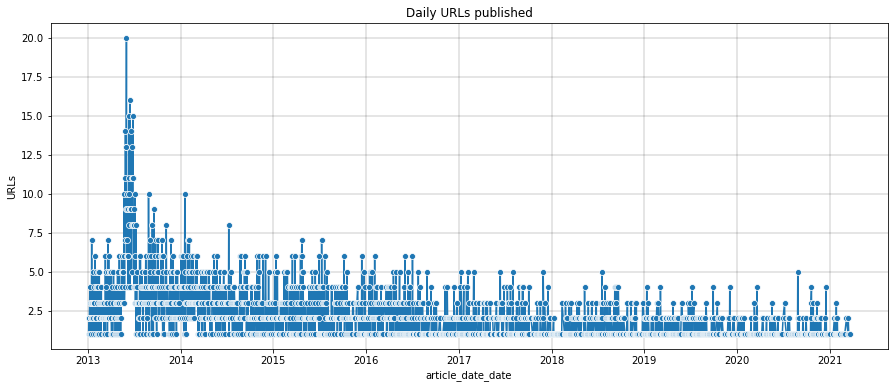

In [12]:
plotLine_URLs('article_date_date',df_plotViz)

### 2. EDA Comment

In [13]:
cursor_thread = col_thread.find()
df_thr_process = pd.DataFrame(cursor_thread)

In [14]:
df_thr_process = pd.merge(df_thr_process, df_plotViz,how='inner',on='URLs')
df_thr_process.drop(columns=['_id_x','_id_y','headline_x','Retrived_date'],inplace=True)
df_thr_process.rename(columns={"headline_y":"headline"},inplace=True)

In [15]:
df_thr_process.columns

Index(['URLs', 'token_headline', 't_mention_dairy', 't_mention_product',
       't_mention_brand', 'headline', 'text', 'article_date',
       'article_date_date', 'article_date_year'],
      dtype='object')

In [16]:
cursor_comment = col_comment.find()
df_cmt_process = pd.DataFrame(cursor_comment)

In [17]:
# คัด headline ที่พูดถึง domain นมทั้งหมด
df_urls_milk = df_thr_process[(df_thr_process.t_mention_dairy.str.len() != 0)]

In [18]:
# เมื่อ join กันแล้ว คอมเม้นทุกคอมเม้นจะอยู่ใน domain นมทั้งหมด
df_join_url = pd.merge(df_urls_milk,df_cmt_process,how='inner',on='URLs')
df_join_url.drop(columns=['_id','text_x','headline_y'],inplace=True)
df_join_url.rename(columns={"t_mention_dairy":"h_mention_dairy","t_mention_product":"h_mention_product","t_mention_brand":"h_mention_brand"
                            ,"headline_x":"headline","text_y":"text"},inplace=True)
df_join_url.set_index('commentId',inplace=True)

In [19]:
df_join_url.head(2)

,URLs,token_headline,h_mention_dairy,h_mention_product,h_mention_brand,headline,article_date,article_date_date,article_date_year,text,Retrived_date,token_text,cmt_mention_dairy,cmt_mention_product,cmt_mention_brand
commentId,,,,,,,,,,,,,,,
1,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หายาก]",[นม],None,[เมจิ],นมเมจิรสหวานทำไมหายากจังคะ,2020-05-05 13:22:59,2020-05-05,2020,เมื่อก่อนหลายปีมาแล้ว ในเซเว่นยังมีนมเมจิรสหวา...,2021-03-22 21:00:24.737,"[ปี, 7-Eleven, ยังมี, นม, เมจิ, รสหวาน, ขาย, อ...","[นม, นม]",None,[เมจิ]
2,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หายาก]",[นม],None,[เมจิ],นมเมจิรสหวานทำไมหายากจังคะ,2020-05-05 13:22:59,2020-05-05,2020,เบาหวานครับ แฮ่ๆ,2021-03-22 21:00:24.737,"[เบาหวาน, แฮ่]",[],None,[]


In [20]:
df_join_url.shape

(17704, 15)

In [21]:
dictionary = gensim.corpora.Dictionary(df_join_url['token_text'])

In [22]:
df_join_url['token_bow'] = df_join_url["token_text"].map(dictionary.doc2bow)
df_join_url['token_text_cnt'] = df_join_url["token_bow"].apply(lambda x:[(dictionary[id_], frequence) for id_, frequence in x])

In [23]:
df_join_url.drop(columns=['Retrived_date','token_bow'],inplace=True)

In [24]:
df_join_url.insert(3,'docs_mention_domain',value=None)
#df_join_url.insert(4,'docs_mention_product',value=None)
df_join_url.insert(4,'docs_mention_brand',value=None)

In [25]:
#Line 29
print('จำนวน headline ที่มีการพูดถึง dairy :',df_urls_milk.shape[0])
print('จำนวน comment จากกระทู้ที่มีการพูดถึง dairy :',df_join_url.shape[0])
print('* comment ภายกระทู้ที่มีการพูดถึง dairy')

จำนวน headline ที่มีการพูดถึง dairy : 1133
จำนวน comment จากกระทู้ที่มีการพูดถึง dairy : 17704
* comment ภายกระทู้ที่มีการพูดถึง dairy


In [26]:
#Line 30
print('จำนวน headline ที่มีการพูดถึง product :',df_urls_milk[df_urls_milk['t_mention_product'].str.len()>2].shape[0])
print('จำนวน headline ที่ไม่มีการพูดถึง product :',df_urls_milk[df_urls_milk['t_mention_product'].str.len()<=2].shape[0])
print('จำนวน comment ที่มีการพูดถึง product :',df_join_url[df_join_url['cmt_mention_product'].str.len()>2].shape[0])
print('จำนวน comment ที่ไม่พูดถึง product เลย :',df_join_url[df_join_url['cmt_mention_product'].str.len()<=2].shape[0])
print('* ยังไม่ impute product จากขั้วกระทู้')

จำนวน headline ที่มีการพูดถึง product : 0
จำนวน headline ที่ไม่มีการพูดถึง product : 0
จำนวน comment ที่มีการพูดถึง product : 0
จำนวน comment ที่ไม่พูดถึง product เลย : 0
* ยังไม่ impute product จากขั้วกระทู้


In [27]:
#Line 31
print('จำนวน headline ที่มีการพูดถึง brand :',df_urls_milk[df_urls_milk['t_mention_brand'].str.len()>2].shape[0])
print('จำนวน headline ที่ไม่มีการพูดถึง brand :',df_urls_milk[df_urls_milk['t_mention_brand'].str.len()<=2].shape[0])
print('จำนวน comment ที่มีการพูดถึง brand :',df_join_url[df_join_url['cmt_mention_brand'].str.len()>2].shape[0])
print('จำนวน comment ที่ไม่พูดถึง brand เลย :',df_join_url[df_join_url['cmt_mention_brand'].str.len()<=2].shape[0])
print('* ยังไม่ impute brand จากขั้วกระทู้')

จำนวน headline ที่มีการพูดถึง brand : 4
จำนวน headline ที่ไม่มีการพูดถึง brand : 1129
จำนวน comment ที่มีการพูดถึง brand : 412
จำนวน comment ที่ไม่พูดถึง brand เลย : 17292
* ยังไม่ impute brand จากขั้วกระทู้


### Impute brand & product เข้า comment และสรุปก่อนเข้า BoW

Impute จากหัวกระทู้

1. headline มี comment มี เอา comment
2. headline มี comment ไม่มี เอา headline
3. headline ไม่มี comment มี เอา comment
4. ไม่มีทั้งคู่ ปล่อยไป

In [28]:
for i,e in enumerate(df_join_url.index,0):
    if ((len(df_join_url.h_mention_dairy.iloc[i]) > 0) & (len(df_join_url.cmt_mention_dairy.iloc[i]) > 0)):         # 1.
        df_join_url['docs_mention_domain'].iloc[i] = df_join_url.cmt_mention_dairy.iloc[i]
    elif  ((len(df_join_url.h_mention_dairy.iloc[i]) > 0) & (len(df_join_url.cmt_mention_dairy.iloc[i]) == 0)):  # 2.
        df_join_url['docs_mention_domain'].iloc[i] = df_join_url.h_mention_dairy.iloc[i]
    elif  ((len(df_join_url.h_mention_dairy.iloc[i]) == 0) & (len(df_join_url.cmt_mention_dairy.iloc[i]) > 0)):  # 3.
        df_join_url['docs_mention_domain'].iloc[i] = df_join_url.cmt_mention_dairy.iloc[i]
    else:
        df_join_url['docs_mention_domain'].iloc[i] = None

In [29]:
for i,e in enumerate(df_join_url.index,0):
    if (len(df_join_url.h_mention_brand.iloc[i]) > 0) & (len(df_join_url.cmt_mention_brand.iloc[i]) > 0):         # 1.
        df_join_url['docs_mention_brand'].iloc[i] = df_join_url.cmt_mention_brand.iloc[i]
    elif  (len(df_join_url.h_mention_brand.iloc[i]) > 0) & (len(df_join_url.cmt_mention_brand.iloc[i]) == 0):  # 2.
        df_join_url['docs_mention_brand'].iloc[i] = df_join_url.h_mention_brand.iloc[i]
    elif  (len(df_join_url.h_mention_brand.iloc[i]) == 0) & (len(df_join_url.cmt_mention_brand.iloc[i]) > 0):  # 3.
        df_join_url['docs_mention_brand'].iloc[i] = df_join_url.cmt_mention_brand.iloc[i]
    else:
        df_join_url['docs_mention_brand'].iloc[i] = None

In [30]:
df_join_url.drop(columns=['h_mention_dairy','h_mention_product','h_mention_brand'
                          ,'cmt_mention_dairy','cmt_mention_product','cmt_mention_brand'],inplace=True)

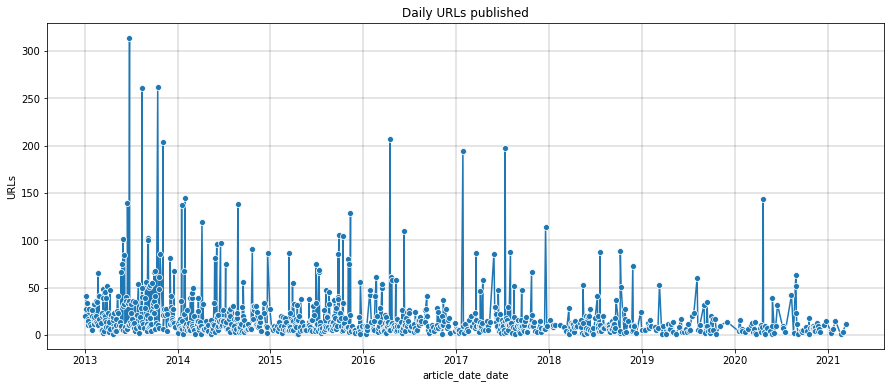

In [31]:
# Domain Reduce
df_plotViz = df_join_url.copy()
df_plotViz.drop_duplicates(subset='URLs',keep='first',ignore_index=True)
plotLine_URLs('article_date_date',df_plotViz)

### สรุปผลหลัง Impute

In [32]:
df_url_eda = df_join_url.copy()
df_url_eda['mention_domain_count'] = df_url_eda['docs_mention_domain'].apply(lambda x: 0 if x is None else len(x))
#df_url_eda['mention_product_count'] = df_url_eda['mention_product'].apply(lambda x: 0 if x is None else len(x))
df_url_eda['mention_brand_count'] = df_url_eda['docs_mention_brand'].apply(lambda x: 0 if x is None else len(x))

In [33]:
df_url_eda.head(2)

,URLs,token_headline,docs_mention_domain,docs_mention_brand,headline,article_date,article_date_date,article_date_year,text,token_text,token_text_cnt,mention_domain_count,mention_brand_count
commentId,,,,,,,,,,,,,
1,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หายาก]","[นม, นม]",[เมจิ],นมเมจิรสหวานทำไมหายากจังคะ,2020-05-05 13:22:59,2020-05-05,2020,เมื่อก่อนหลายปีมาแล้ว ในเซเว่นยังมีนมเมจิรสหวา...,"[ปี, 7-Eleven, ยังมี, นม, เมจิ, รสหวาน, ขาย, อ...","[(7-Eleven, 1), (tops, 1), (กลาง, 1), (ขวด, 2)...",2,1
2,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หายาก]",[นม],[เมจิ],นมเมจิรสหวานทำไมหายากจังคะ,2020-05-05 13:22:59,2020-05-05,2020,เบาหวานครับ แฮ่ๆ,"[เบาหวาน, แฮ่]","[(เบาหวาน, 1), (แฮ่, 1)]",1,1


In [34]:
df_url_eda.shape

(17704, 13)

In [35]:
print('จำนวนความเห็นที่มีการพูดถึง brand :',df_url_eda[df_url_eda['mention_brand_count']>0].shape[0])
print('จำนวนความเห็นที่ไม่พูดถึง brand เลย :',df_url_eda[df_url_eda['mention_brand_count']<=0].shape[0])
print('* impute product จากขั้วกระทู้แล้ว')

จำนวนความเห็นที่มีการพูดถึง brand : 5324
จำนวนความเห็นที่ไม่พูดถึง brand เลย : 12380
* impute product จากขั้วกระทู้แล้ว


### ค้นหา Flavor ที่มีอยู่จริงในตลาดจาก Social

In [49]:
def freq_brand(x):
    #e = eval(x)
    e = x
    e.sort()
    f = [(k,len(list(g))) for k, g in groupby(e)]
    return list(set(f))

สรุปผล ลง Excel ไปทำ EDA ต่อได้

In [37]:
df_url_eda = df_join_url.copy()
df_url_eda['docs_mention_domain'] = df_url_eda['docs_mention_domain'].apply(lambda x: x if x is None else freq_brand(x))
df_url_eda['docs_mention_brand'] = df_url_eda['docs_mention_brand'].apply(lambda x: x if x is None else freq_brand(x))

In [38]:
df_url_eda.columns

Index(['URLs', 'token_headline', 'docs_mention_domain', 'docs_mention_brand',
       'headline', 'article_date', 'article_date_date', 'article_date_year',
       'text', 'token_text', 'token_text_cnt'],
      dtype='object')

In [39]:
df_a = pd.concat([pd.DataFrame(s,columns=['w','c']).set_index('w') for s in df_url_eda["docs_mention_domain"]], axis=1, sort=False).fillna(0).T.set_index(df_url_eda.index)
df_b = pd.concat([pd.DataFrame(s,columns=['w','c']).set_index('w') for s in df_url_eda["docs_mention_brand"]], axis=1, sort=False).fillna(0).T.set_index(df_url_eda.index)
#df_c = pd.concat([pd.DataFrame(s,columns=['w','c']).set_index('w') for s in df_final["mention_product"]], axis=1, sort=False).fillna(0).T.set_index(df_final.index)

In [40]:
df_a.sum().sort_values(ascending=False)

นม              16068.0
นมแม่            2385.0
นมผง             2320.0
กินนม            2206.0
โยเกิร์ต         2093.0
นมสด             2046.0
นมวัว            1803.0
นมกล่อง          1711.0
ดื่มนม           1631.0
uht              1068.0
นมเปรี้ยว        1059.0
พาสเจอร์ไรส์      938.0
นมถั่วเหลือง      688.0
นมข้น             492.0
นมโค              490.0
นมแพะ             434.0
นมโรงเรียน        392.0
ขวดนม             219.0
น้ำนมโค            95.0
หย่านม             91.0
non dairy           6.0
nondairy            4.0
dtype: float64

In [41]:
df_b.sum().sort_values(ascending=False)

เมจิ           1885.0
ไทยเดนมาร์ค    1458.0
โฟร์โมสต์      1254.0
ดัชมิลล์        891.0
จิตรลดา         781.0
หนองโพ          606.0
โชคชัย          217.0
เอ็มมิลค์        99.0
บีทาเก้น         72.0
แดรี่โฮม         55.0
คาเนชั่น         37.0
แมคโนเลีย         4.0
dtype: float64

### เก็บข้อมูลที่ Filter Domain นมเปรี้ยว นมถั่วเหลือง UHT ออก ลง MongoDB

In [42]:
df_a[(df_a['นมเปรี้ยว']>0)|(df_a['uht']>0)|(df_a['นมกล่อง']>0)|(df_a['โยเกิร์ต']>0)]

,นม,นมสด,กินนม,ดื่มนม,นมวัว,นมกล่อง,นมแพะ,นมผง,uht,นมโรงเรียน,...,นมข้น,พาสเจอร์ไรส์,นมโค,โยเกิร์ต,นมแม่,หย่านม,ขวดนม,nondairy,น้ำนมโค,non dairy
commentId,,,,,,,,,,,,,,,,,,,,,
32,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225082,4.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df_process_comment = pd.merge(df_url_eda, df_a.reset_index().iloc[:,0],how='inner',on='commentId')

In [47]:
def create_InsertMany_comments(df):
    listofdict = []
    for c,lx in enumerate(df.index,0):
        info = {
            "commentId":int(lx),
            "URLs": df.URLs[c],
            "token_headline":df.token_headline[c],
            "docs_mention_domain": df.docs_mention_domain[c],
            "docs_mention_brand": df.docs_mention_brand[c],
            "headline":df.headline[c],
            "article_date": df.article_date[c],
            "text": df.text[c],
            "token_text": df.token_text[c],
            "token_text_cnt": df.token_text_cnt[c]
        }
        listofdict.append(info)
    return listofdict

In [45]:
col_claen = mydb["NIDA_PPSN_CLEANED_DATA"]

In [48]:
col_claen.delete_many({})
process_data = create_InsertMany_comments(df_process_comment)
col_claen.insert_many(process_data)